In [1]:
%load_ext autoreload

%autoreload 2

In [121]:
PATH = "/Users/seanohagan/projects/conformal_tree/"

# Load Packages

In [122]:
from uacqr import uacqr
from helper import generate_data
from experiment import experiment

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial

from conformal_tree._data import sin_simul as data_gen

# Define Data Generating Process

In a conditional gaussian setting, set the conditional expectation and the conditional noise

In [124]:
def cond_exp(x):
    return np.sin(1/(x[:,0]**3))

def noise_sd_fn(x):
    return 1*x[:,0]**2

In [125]:
x_dist = partial(np.random.beta, a=1.2, b=0.8)

In [126]:
n=100
T=800 # number of test points
p=1
n0 = int(n/2) # number of training points

# Simulate Data

In [127]:
np.random.seed(1)
data = generate_data(n+T, p, cond_exp, noise_sd_fn, x_dist)

In [128]:
x = data[0]
y = data[1]

if len(x.shape)==1:
    x = x.reshape(-1,1)

x_train = x[:n0]
y_train = y[:n0]

x_calib = x[n0:n]
y_calib = y[n0:n]

x_test = x[n:]
y_test = y[n:]

Text(0.5, 1.0, 'Y versus X')

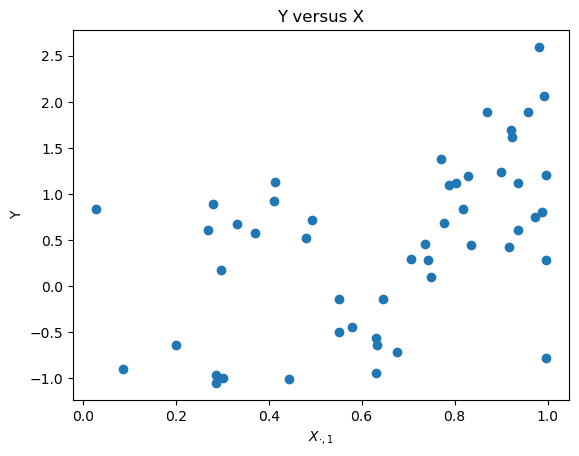

In [129]:
plt.scatter(x_train[:,0], y_train)
plt.xlabel('$X_{\cdot,1}$')
plt.ylabel('Y')
plt.title('Y versus X')

# Run LACQR

Define model hyperparameters

In [130]:
nn_params = {'dropout':0, 'epochs':1000, 'hidden_size':100, 'lr':1e-3, 'batch_norm':True,
             'batch_size':2, 'normalize':True, 'weight_decay':0, 'epoch_model_tracking':True,
             "running_batch_norm":True, "train_first_batch_norm":True, "use_gpu":False}


Use uacqr class to compute all of our methods at once.

In [131]:
%%time
lacqr_results = uacqr(nn_params,
                     bootstrapping_for_uacqrp=False, B=999, random_state=42, uacqrs_agg='std', model_type='neural_net',
                     extraneous_quantiles=['mean'])
lacqr_results.fit(x_train, y_train)
lacqr_results.calibrate(x_calib, y_calib)
lacqr_results.evaluate(x_test, y_test)

CPU times: user 19.5 s, sys: 8.54 s, total: 28 s
Wall time: 23.9 s


{'interval_score_loss': {'UACQR-P': 2.924612410995837,
  'UACQR-S': 2.8477559196920628,
  'CQR': 3.2685456568411233,
  'CQR-r': 4.1352497444663125,
  'Base': 5.321735756260241},
 'test_coverage': {'UACQR-P': 0.91125,
  'UACQR-S': 0.90875,
  'CQR': 0.88375,
  'CQR-r': 0.88375,
  'Base': 0.5275},
 'average_length_test': {'UACQR-P': 2.4252503,
  'UACQR-S': 2.3267796,
  'CQR': 2.4874392,
  'CQR-r': 3.06998,
  'Base': 1.183464}}

# Figure 1

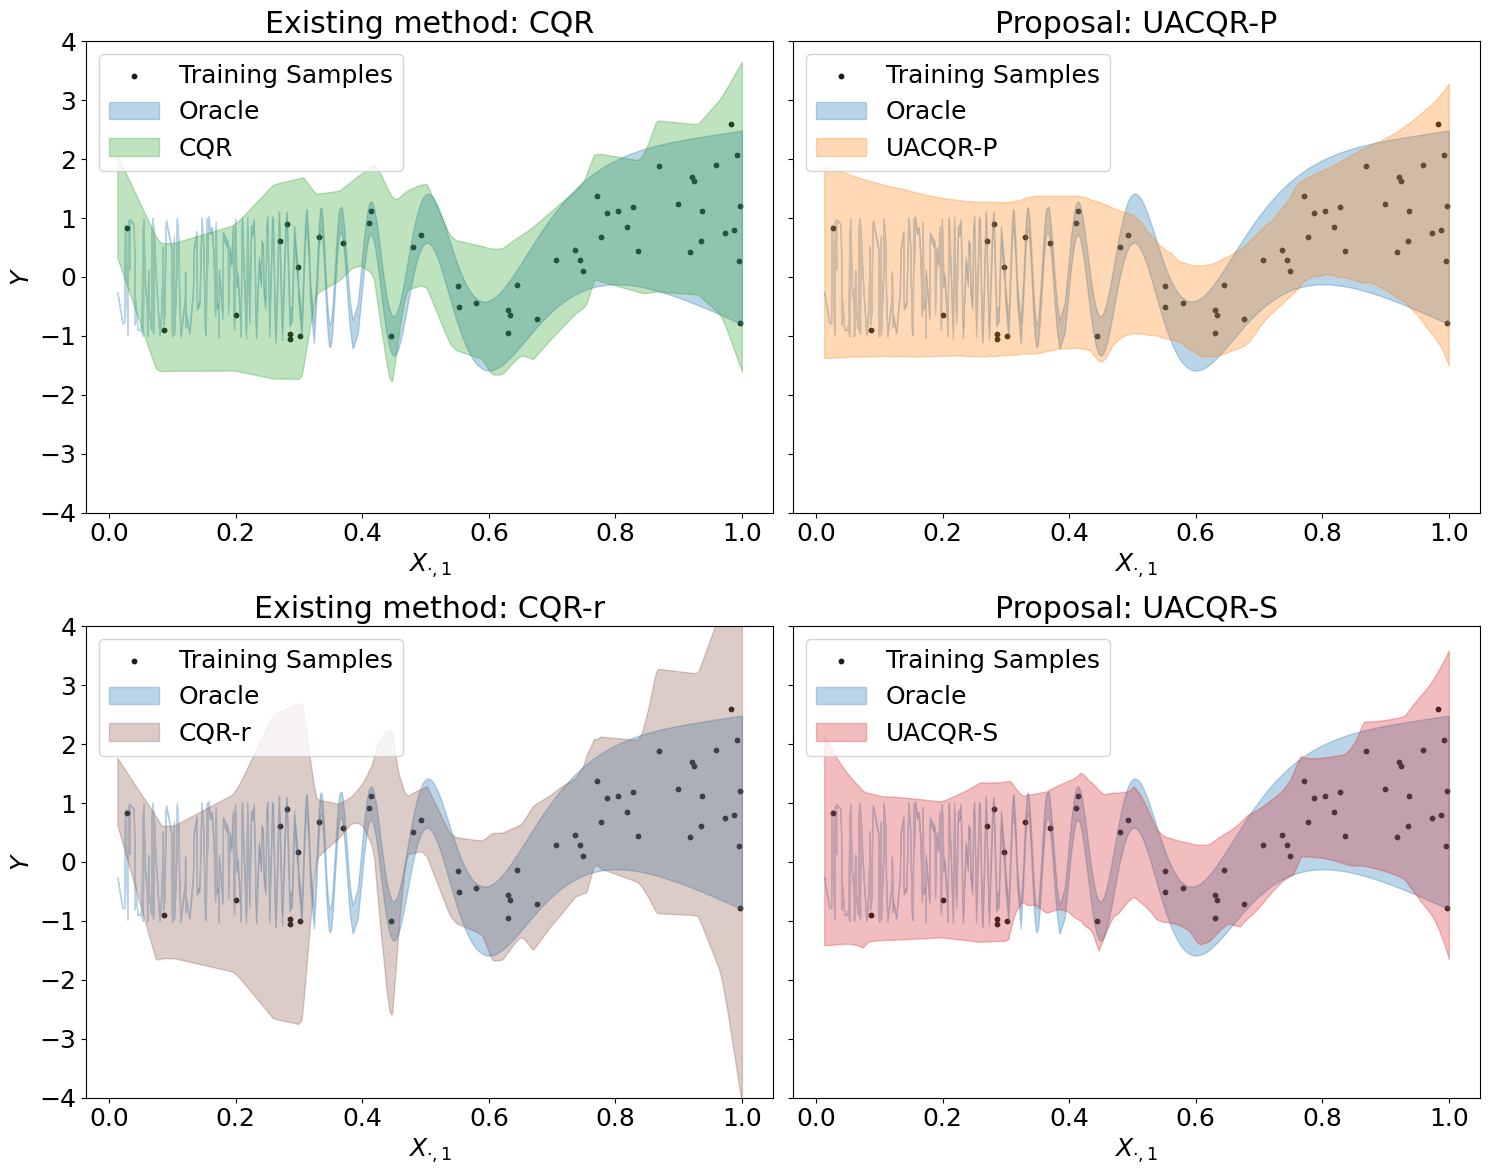

In [132]:
lacqr_results.plot_simple(cond_exp, noise_sd_fn,
                         xlabel='$X_{\cdot,1}$', expanded=True)
plt.tight_layout()
# plt.savefig('figure_1_aistats.pdf')

# Figure 1 with a comparison with conformal tree

In [198]:
from scipy.stats import norm

def plot_with_tree(self, cond_exp, noise_sd_fn, tree_obj, feature_for_x_axis=0, sharey=True, suptitle=None,
            ylabel = '$Y$', xlabel = '$X$', expanded=False):

        colors = {'UACQR-P':'tab:orange', 'CQR':'tab:green', 'UACQR-S':'tab:red', 'Base Estimator':'tab:purple',
          'CQR-m with oracle info':'tab:brown','UACQR-S with oracle info':'tab:pink', 'Truth':'tab:blue',
          'Median Estimator':'tab:purple', 'ctree':'tab:purple', 'CQR-r':'tab:brown'}

        idxs = self.x_test[:,feature_for_x_axis].argsort()
        idxs_train = self.x_train[:,feature_for_x_axis].argsort()

        x_column = self.x_test[idxs,feature_for_x_axis]
        x_train_column = self.x_train[idxs_train,feature_for_x_axis]

        plt.rcParams['font.size'] = 18
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=sharey, figsize=(24,8))
        # plt.setp((ax1, ax2, ax3), ylim=(-4,4))

        fig.subplots_adjust(top=0.75)
        fig.suptitle(suptitle, fontsize=13)

        ax1.scatter(x_train_column, self.y_train[idxs_train], color='0.1', alpha=1, s=10, label='Training Samples')
        ax1.plot(self.x_test[np.argsort(self.x_test.flatten())], cond_exp(self.x_test)[np.argsort(self.x_test.flatten())], color="red")
        ax1.fill_between(x_column, (cond_exp(self.x_test) - norm.ppf(self.q_upper/100, 0, noise_sd_fn(self.x_test)))[idxs],
                          (cond_exp(self.x_test) + norm.ppf(self.q_upper/100, 0, noise_sd_fn(self.x_test)))[idxs],
            label='Oracle', color=colors['Truth'], alpha=0.3)
        ax1.fill_between(x_column, self.test_y_lower_cqr[idxs],  self.test_y_upper_cqr[idxs], label='CQR',
                color=colors['CQR'], alpha=0.3)


        ax1.legend(loc='upper left')
        ax1.set_ylabel(ylabel)
        ax1.set_xlabel(xlabel)
        ax1.set_title('Existing method: CQR')


        ax2.scatter(x_train_column, self.y_train[idxs_train], color='0.1', alpha=1, s=10, label='Training Samples')
        ax2.plot(self.x_test[np.argsort(self.x_test.flatten())], cond_exp(self.x_test)[np.argsort(self.x_test.flatten())], color="red")
        ax2.fill_between(x_column, (cond_exp(self.x_test) - norm.ppf(self.q_upper/100, 0, noise_sd_fn(self.x_test)))[idxs],
                          (cond_exp(self.x_test) + norm.ppf(self.q_upper/100, 0, noise_sd_fn(self.x_test)))[idxs],
            label='Oracle',color=colors['Truth'], alpha=0.3)
        ax2.fill_between(x_column, self.test_y_lower[idxs], self.test_y_upper[idxs], label='UACQR-P',
                color=colors['UACQR-P'], alpha=0.3)

        ax2.legend(loc='upper left')
        ax2.set_xlabel(xlabel)
        ax2.set_title('Proposal: UACQR-P')

        ax3.scatter(x_train_column, self.y_train[idxs_train], color='0.1', alpha=1, s=10, label='Training Samples')
        ax3.plot(self.x_test[np.argsort(self.x_test.flatten())], tree_obj.model.predict(self.x_test)[np.argsort(self.x_test.flatten())], color="red")
        ax3.fill_between(x_column, (cond_exp(self.x_test) - norm.ppf(self.q_upper/100, 0, noise_sd_fn(self.x_test)))[idxs],
                          (cond_exp(self.x_test) + norm.ppf(self.q_upper/100, 0, noise_sd_fn(self.x_test)))[idxs],
            label='Oracle',color=colors['Truth'], alpha=0.3)

        tree_lb, tree_ub = tree_obj.test_interval(x_test)
        xti = np.argsort(x_test.flatten())
        ax3.fill_between(x_test.flatten()[xti], tree_lb[xti], tree_ub[xti], label='Conformal Tree',
                color=colors['ctree'], alpha=0.3)


        ax3.legend(loc='upper left')
        ax3.set_xlabel(xlabel)
        ax3.set_title('Proposal: Conformal Tree')



        plt.rcParams['font.size'] = 10

In [155]:
import sys
sys.path.append("/Users/seanohagan/projects/conformal_tree/")
sys.path.append("/Users/seanohagan/projects/rlabc/")
from conformal_tree import conformal_tree


In [199]:
domain = np.array([[0,1]])

class LambdaModel:
    def predict(self, x):
        return (lambda x: lacqr_results.nn_model.predict(x)[1, :])(x)
model_obj = LambdaModel()

ct = conformal_tree.CTree(model_obj, domain)
y_model = lacqr_results.nn_model.predict(x_calib)[1,:]
y_lb, y_ub, cg = ct.calibrate(x_calib, y_calib, y_model, 0.1)

In [200]:
y_lb_test, y_ub_test = ct.test_interval(x_calib)

In [201]:
np.sum(np.abs(y_lb-y_lb_test))
np.sum(np.abs(y_ub-y_ub_test))

0.0

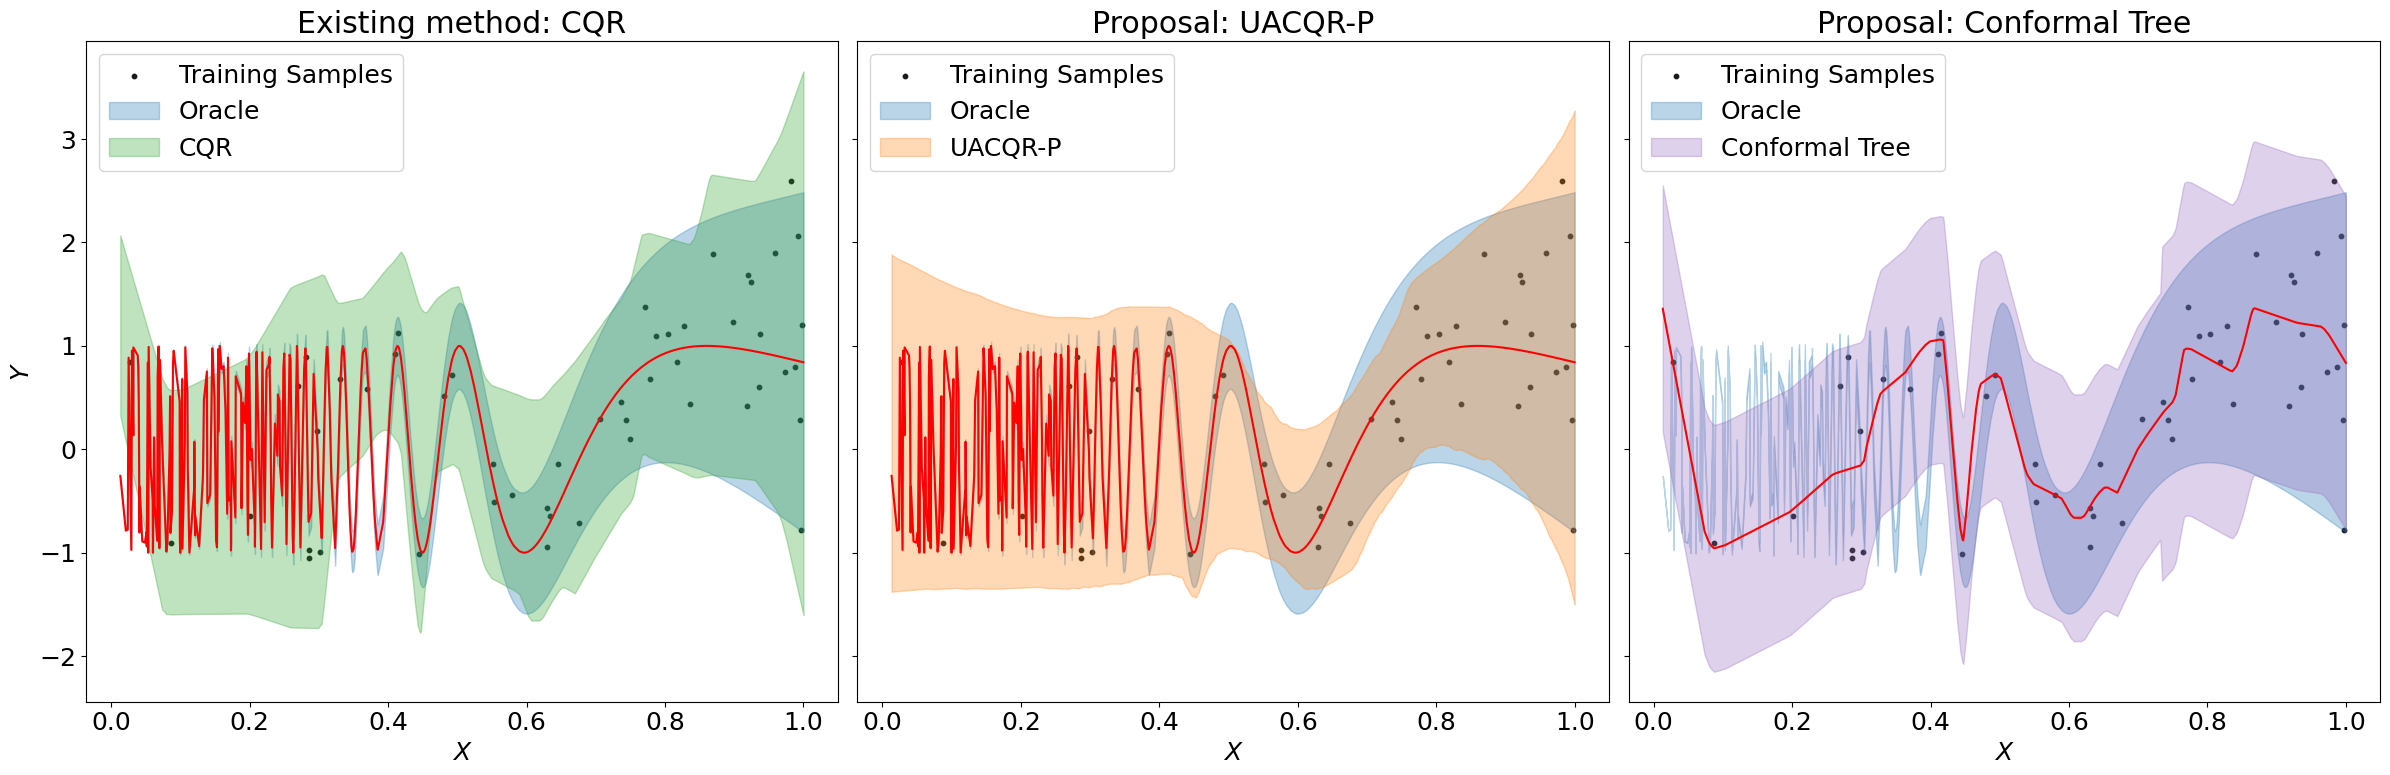

In [202]:
plot_with_tree(lacqr_results, cond_exp, noise_sd_fn, ct)
plt.tight_layout()

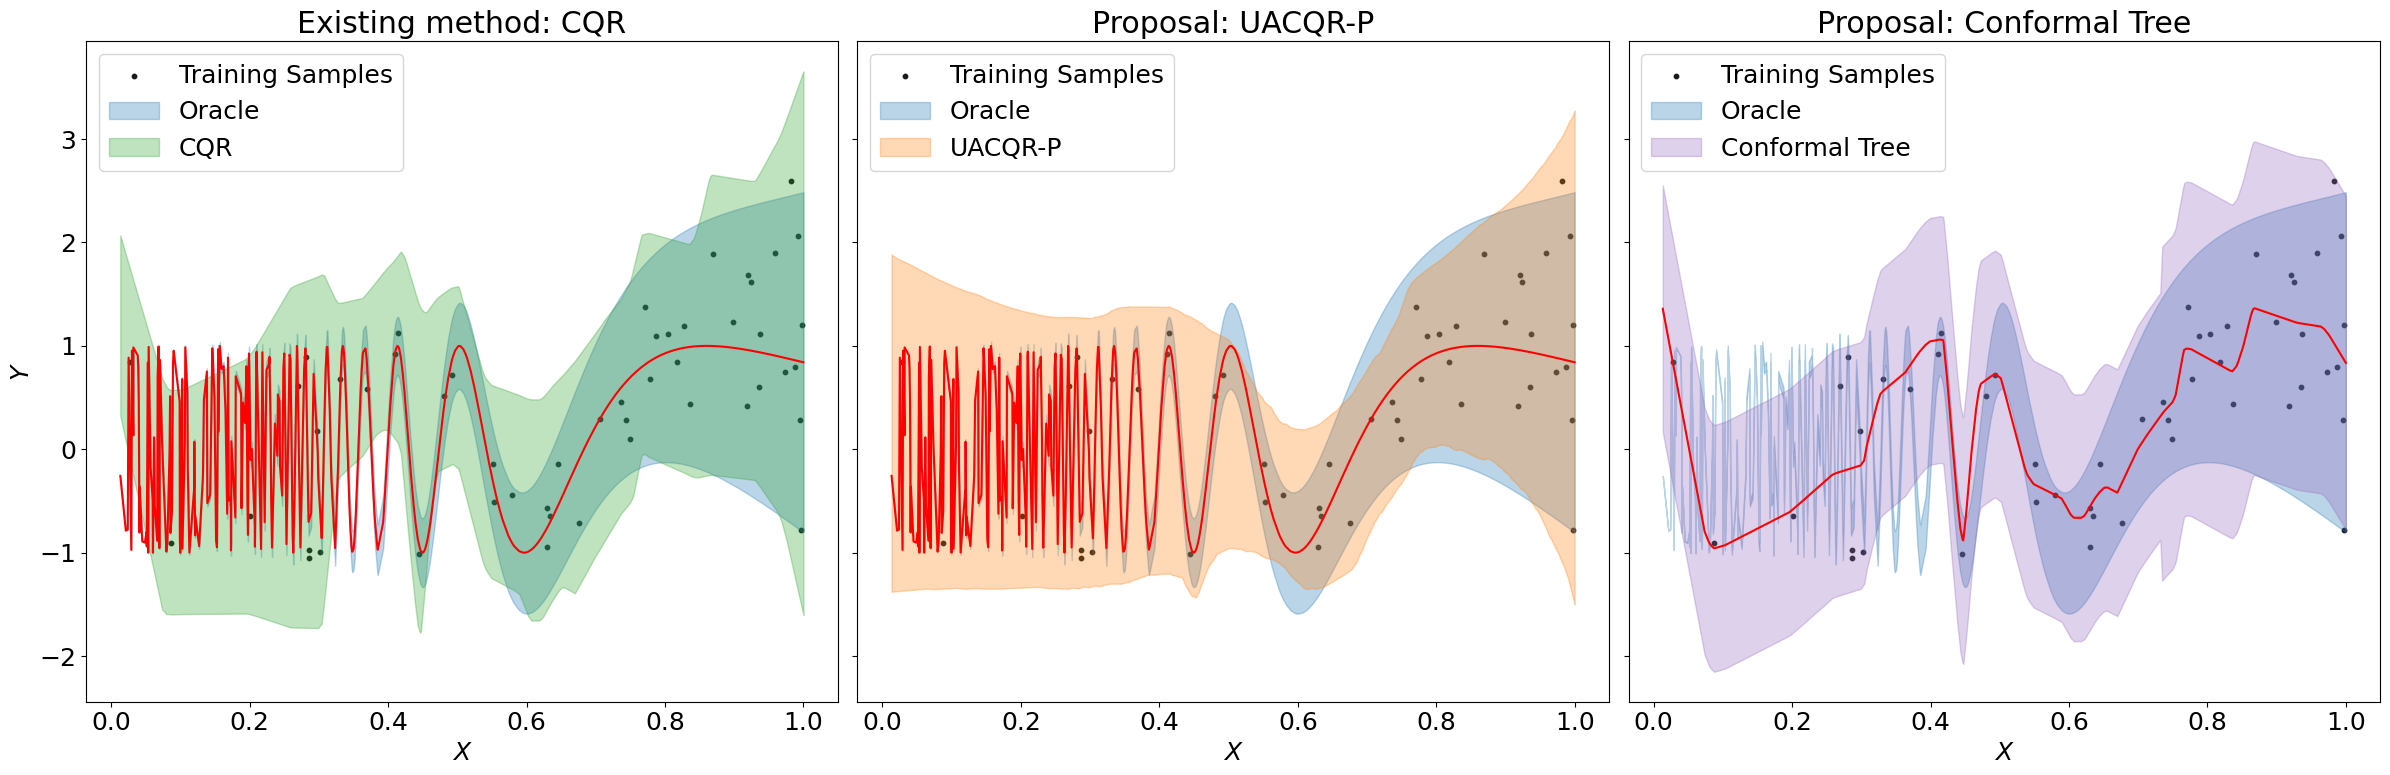

In [204]:
plot_with_tree(lacqr_results, cond_exp, noise_sd_fn, ct)
plt.tight_layout()

# Our Experiments

In [205]:
from conformal_tree._nets import network_toy as nt
import torch
import pickle
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def compare_with_opts(opt1, opt2):

    path = F"{PATH}developing_ipynb/sinusodal_experiment_finished/trained_nets/sin_opt{opt1}{opt2}.net"
    net = nt.MLP(input_dim=1, out_dim=1, device = DEVICE, factor=128)
    net.load_state_dict(torch.load(path, map_location=DEVICE))
    net.eval()


    with open(F"{PATH}developing_ipynb/sinusodal_experiment_finished/trained_nets/sin_opt{opt1}{opt2}.dat", 'rb') as file:
        cache = pickle.load(file)

    opt1,opt2 = cache["opt1"], cache["opt2"]
    (x_train,y_train),(x_calib,y_calib),(x_test, y_test) = cache["data"]

    ## Error calculation
    X_calib, Y_calib = torch.from_numpy(x_calib).to(DEVICE).float(),torch.from_numpy(y_calib).to(DEVICE)

    with torch.no_grad():
        out_calib = net(X_calib).cpu().view(-1)

    X_calib = X_calib.numpy()
    Y_calib = Y_calib.numpy()
    y_model = out_calib.numpy()

    def cond_exp(x):
        return data_gen.cond_exp(x, option=opt1)

    def noise_sd_fn(x):
        return data_gen.noise_sd_fn(x, option=opt2)

    lacqr_results = uacqr(nn_params,
                         bootstrapping_for_uacqrp=False, B=999, random_state=42, uacqrs_agg='std', model_type='neural_net',
                         extraneous_quantiles=['mean'])
    lacqr_results.fit(x_train, y_train)
    lacqr_results.calibrate(x_calib, y_calib)
    lacqr_results.evaluate(x_test, y_test)

    domain = np.array([[0,1]])
    class LambdaModel:
        def predict(self, x):
            with torch.no_grad():
                out = net(torch.from_numpy(x).to(DEVICE).float()).cpu().view(-1).numpy()
            return out

    model_obj = LambdaModel()
    ct = conformal_tree.CTree(model_obj, domain)

    # ct = conformal_tree.CTree(1)
    y_lb, y_ub, cg = ct.calibrate(X_calib, Y_calib, y_model, 0.1)
    y_lb, y_ub = ct.test_interval(X_calib)

    plot_with_tree(lacqr_results, cond_exp, noise_sd_fn, y_lb, y_ub, model_obj.predict)
    plt.tight_layout()

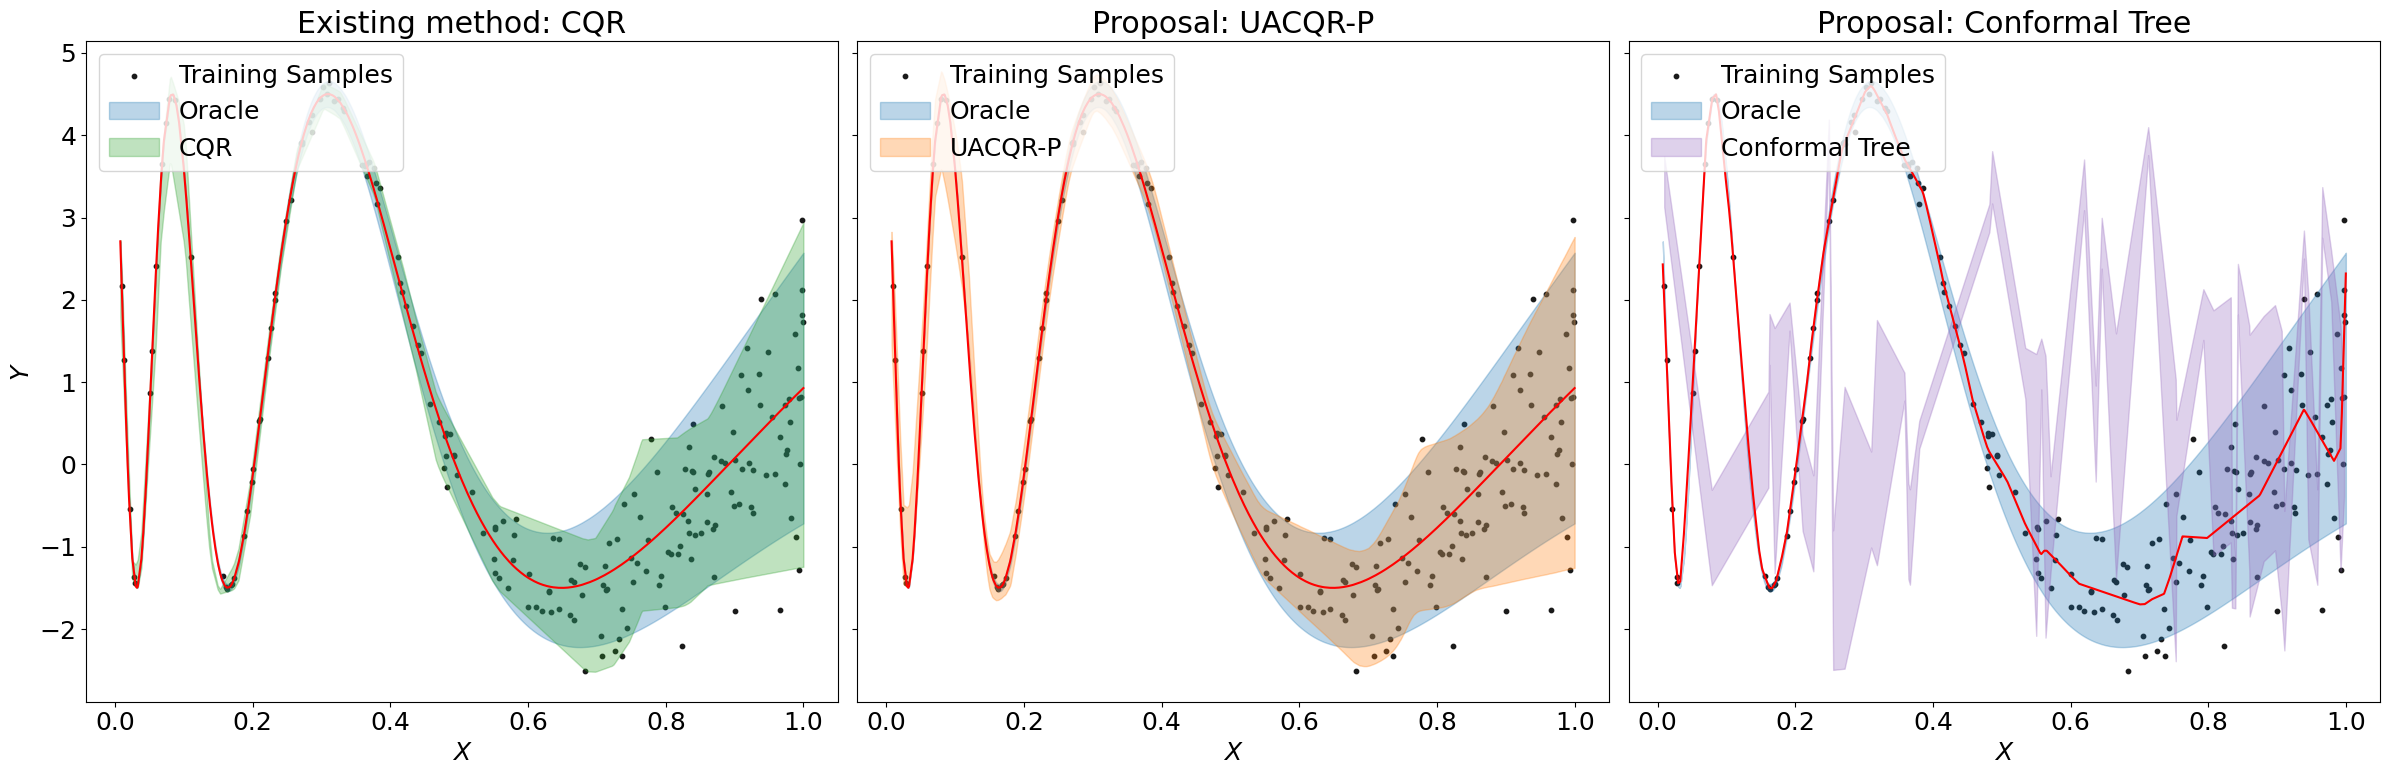

In [190]:
compare_with_opts(opt1=0, opt2=1)

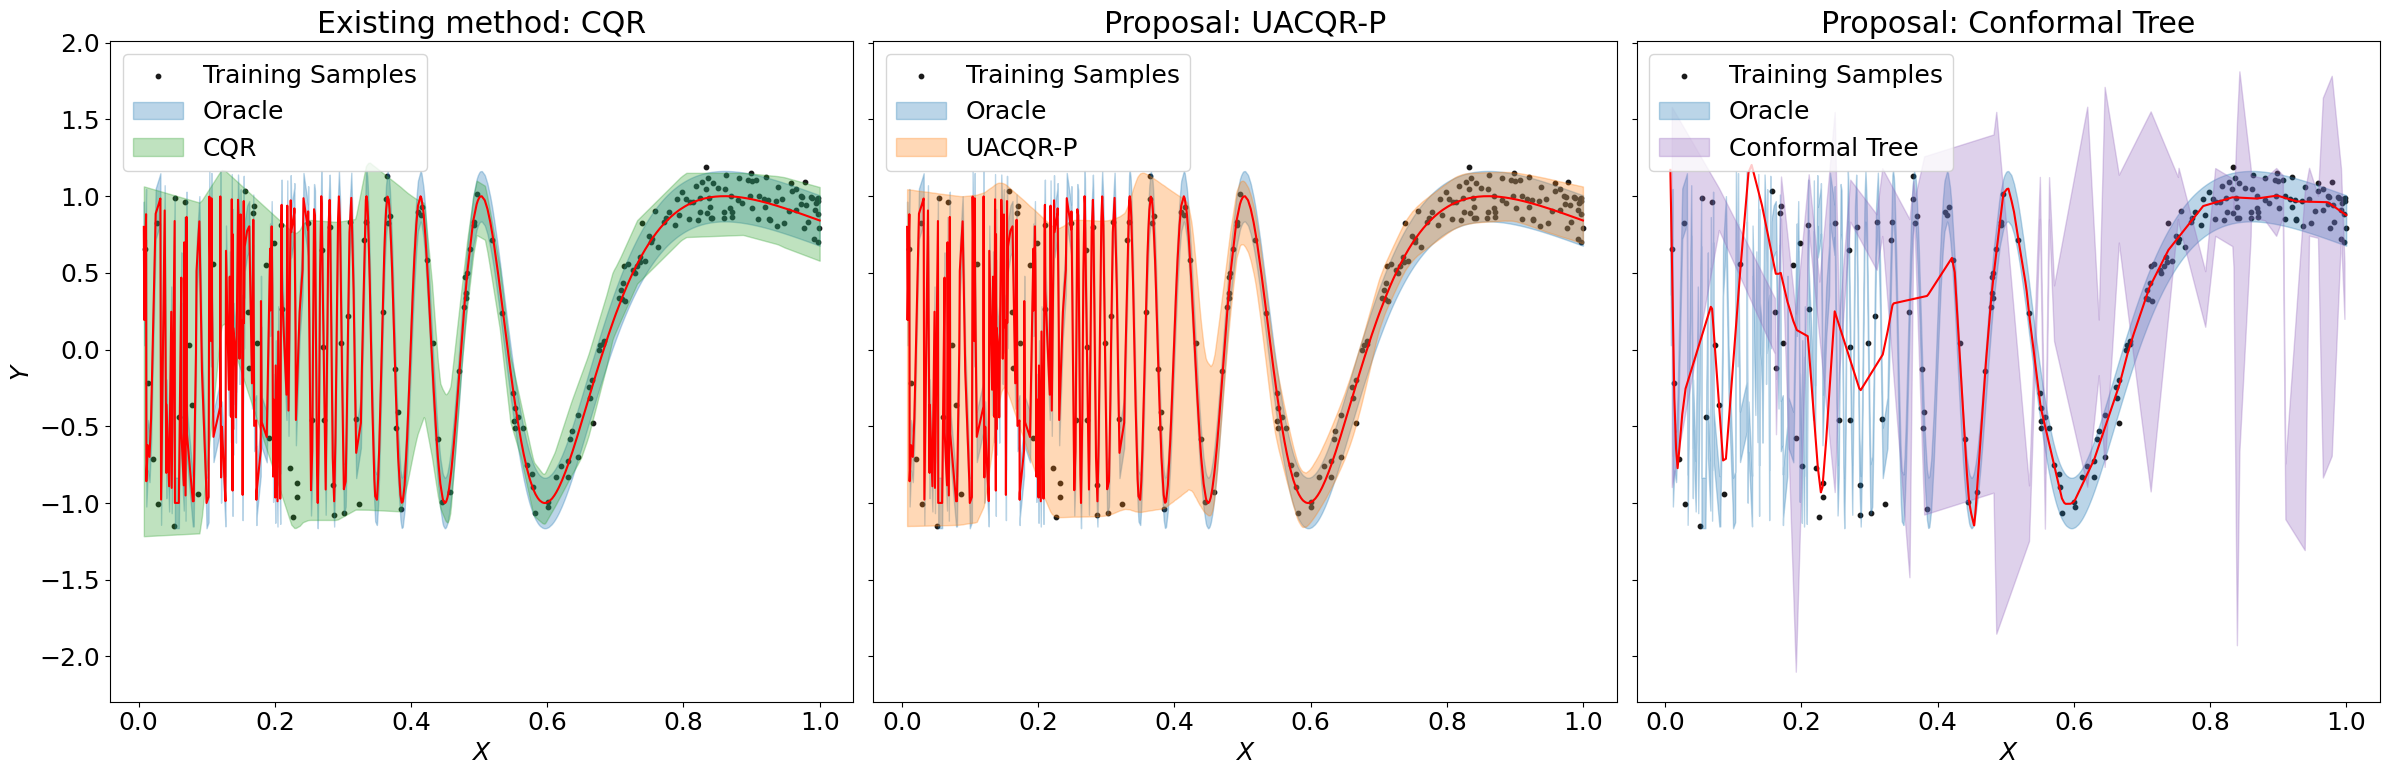

In [191]:
compare_with_opts(opt1=1, opt2=0)

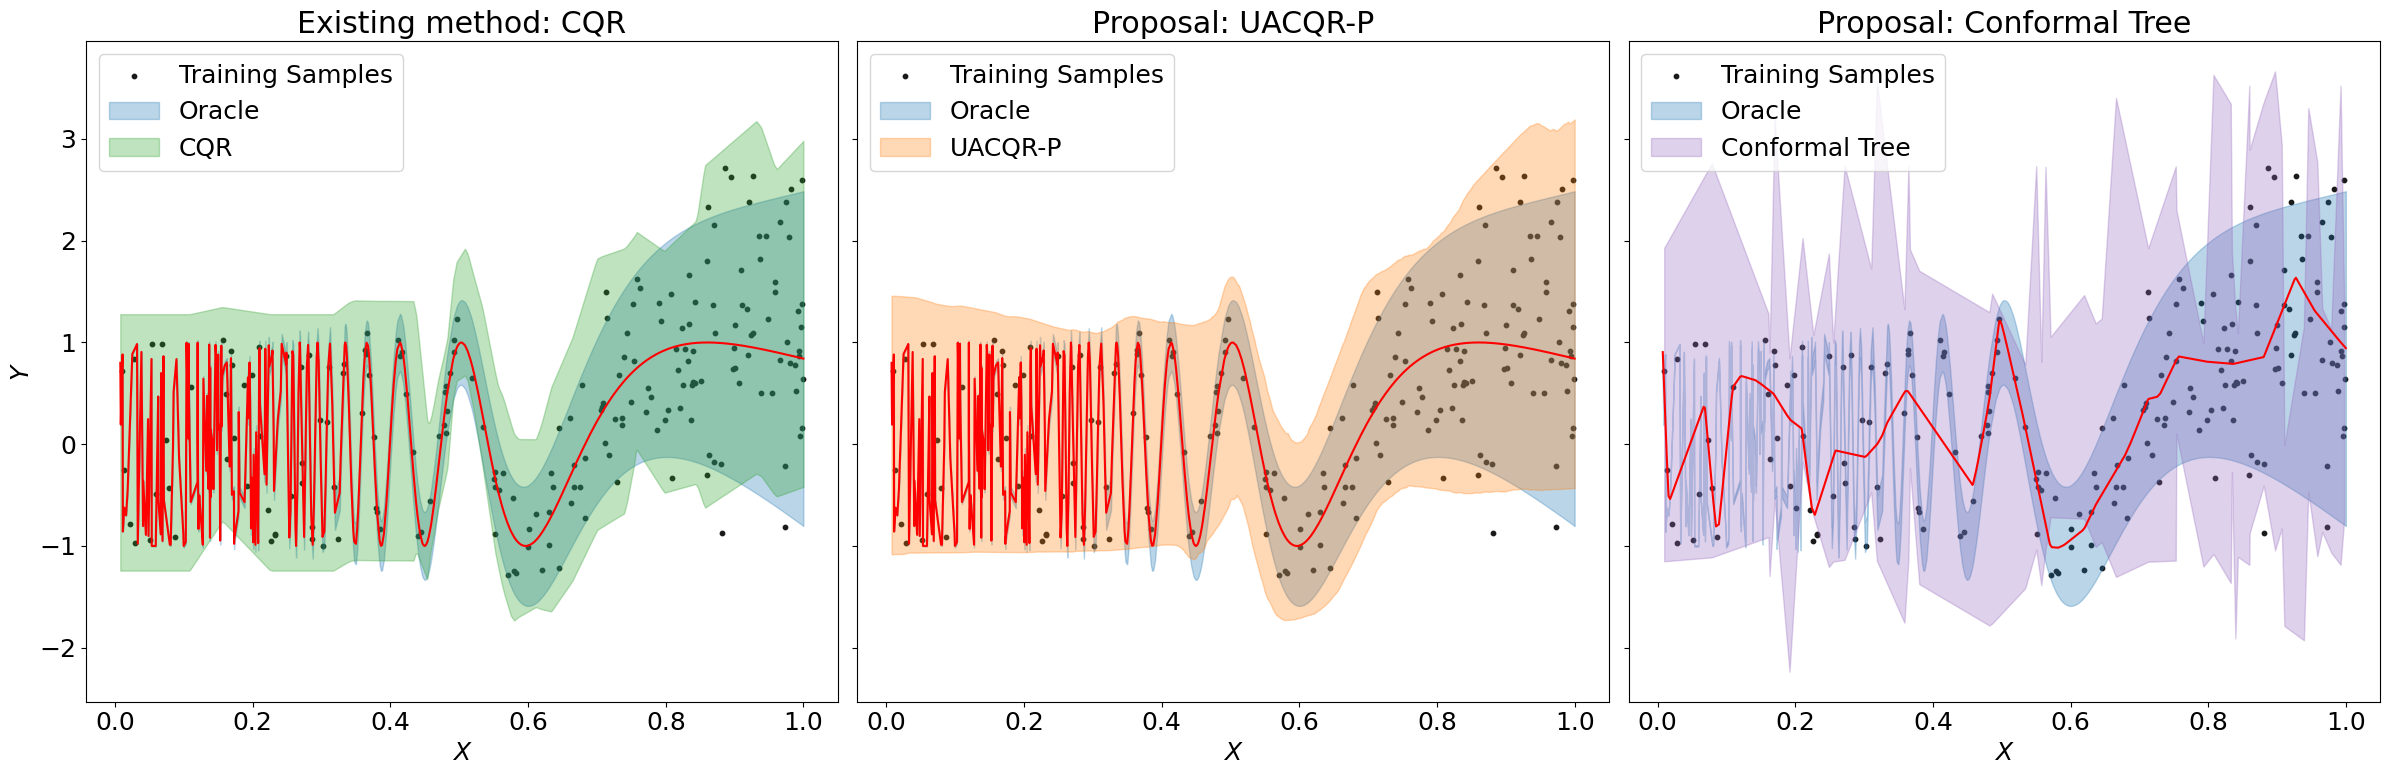

In [186]:
compare_with_opts(opt1=1, opt2=1)